# SCD30 Check
This notebook is simply to check how well the scd30 sensors are working on a select few beacons. 

[Data Import](#Data-Import)

[Data Visualization](#Data-Visualization)
 - [Time Series](#Time-Series)
 - [Heatmaps](#Heatmaps)

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import os

# Pre-Deployment
We look at the data gathered for the sensors before deployment in the UTx000 extension (BPEACE2) study.

In [26]:
beacon_deployment_dict = {'1':[11,13,22,23,25],'2':[1,10,15,16,17],'3':[5,21,24,26,28],'4':[29,30,32,34,38],'5':[41,44],'6':[6,19,36,40,46,48]}
date_deployment_dict = {'1':[datetime(2020,5,25),datetime(2020,6,3)],'2':[datetime(2020,6,2),datetime(2020,6,7)],
                       '3':[datetime(2020,6,6),datetime(2020,6,9)],'4':[datetime(2020,6,8),datetime(2020,6,11)],
                       '5':[datetime(2020,6,10),datetime(2020,6,13)],'6':[datetime(2020,6,12),datetime(2020,6,16)]}

## Data import'

In [28]:
beacon_data = pd.DataFrame()
for deployment in beacon_deployment_dict.keys():
    print(f'Importing pre-deployment data for deployment {deployment}')
    start_time = date_deployment_dict[deployment][0]
    end_time = date_deployment_dict[deployment][1]
    print('\tReading for beacon:')
    for beacon in beacon_deployment_dict[deployment]:
        print(f'\t\t{beacon}')
        beacon_df = pd.DataFrame()
        if beacon < 10:
            number = f'0{beacon}'
        else:
            number = f'{beacon}'
        py3_df = pd.DataFrame()
        for file in os.listdir(f'../data/raw/bpeace2/beacon/B{number}/adafruit/'):
            try:
                day_df = pd.read_csv(f'../data/raw/bpeace2/beacon/B{number}/adafruit/{file}',
                                    index_col='Timestamp',parse_dates=True,infer_datetime_format=True)
                py3_df = pd.concat([py3_df,day_df])
            except Exception as inst:
                print(f'{inst}; filename: {file}')
        py3_df = py3_df.resample('5T').mean()
        py2_df = pd.DataFrame()
        for file in os.listdir(f'../data/raw/bpeace2/beacon/B{number}/sensirion/'):
            try:
                day_df = pd.read_csv(f'../data/raw/bpeace2/beacon/B{number}/sensirion/{file}',
                                index_col='Timestamp',parse_dates=True,infer_datetime_format=True)
            except Exception as inst:
                print(f'{inst}; filename: {file}')
            py2_df = pd.concat([py2_df,day_df])

        py2_df = py2_df.resample('5T').mean()

        beacon_df = py3_df.merge(right=py2_df,left_index=True,right_index=True,how='outer')
        beacon_df['Beacon'] = beacon
        beacon_df = beacon_df[start_time:end_time]

        beacon_data = pd.concat([beacon_data,beacon_df])

Importing pre-deployment data for deployment 1
	Reading for beacon:
		11
		13
		22
		23
		25
Importing pre-deployment data for deployment 2
	Reading for beacon:
		1
		10
		15
		16
		17
Importing pre-deployment data for deployment 3
	Reading for beacon:
		5
		21
		24
		26
		28
Importing pre-deployment data for deployment 4
	Reading for beacon:
		29
		30
		32
		34
		38
Importing pre-deployment data for deployment 5
	Reading for beacon:
		41
		44
Importing pre-deployment data for deployment 6
	Reading for beacon:
		6
		19
		36
		40
		46
		48


# Data Visualization and Analysis
Now we visually inspect the data.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

## Time Series and Offset

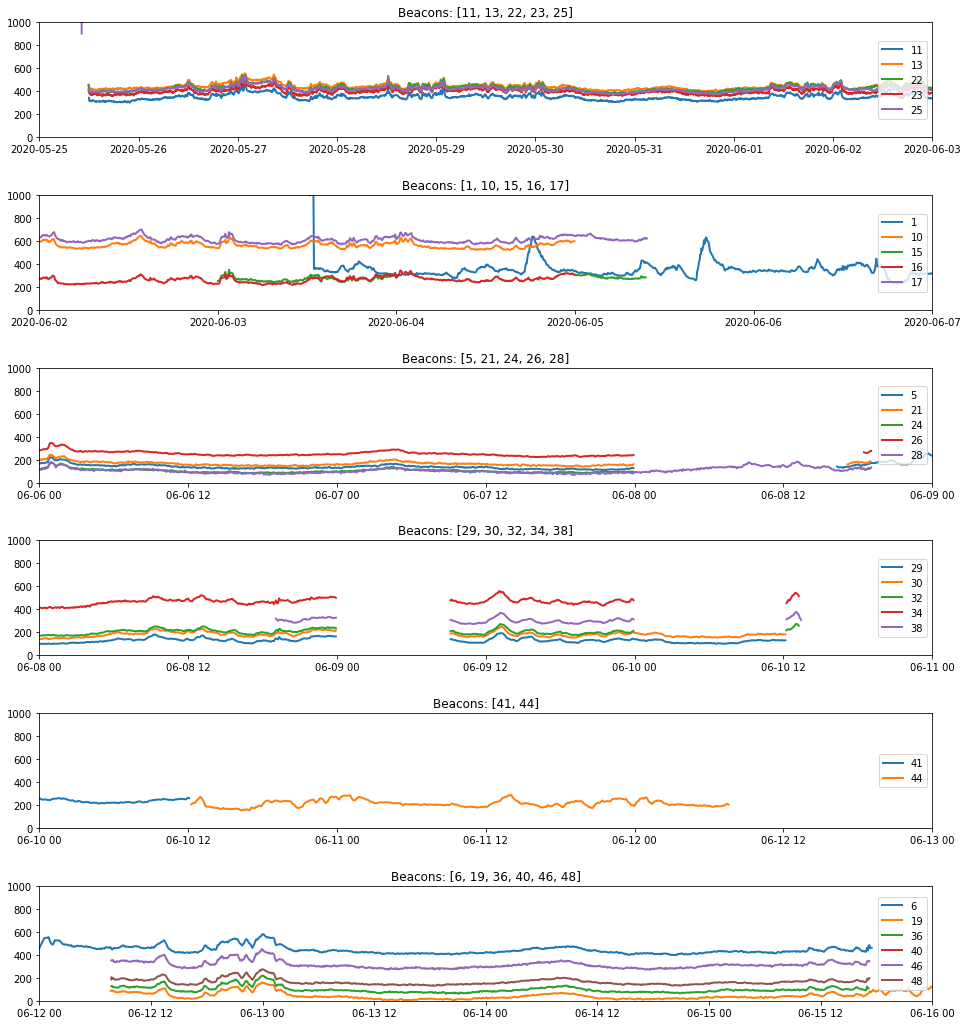

In [57]:
avg_concentrations = []
offsets = []
beacons = []
fig, axes = plt.subplots(6,1,figsize=(16,18))
for deployment in beacon_deployment_dict.keys():
    ax = axes[int(deployment)-1]
    for num in beacon_deployment_dict[deployment]:
        # getting offset
        df_to_plot = beacon_data[beacon_data['Beacon'] == num]
        avg_concentrations.append(np.nanmean(df_to_plot['CO2']))
        offsets.append(np.nanmean(df_to_plot['CO2']) - 400)
        beacons.append(num)
        
        # plotting by deployment
        ax.plot(df_to_plot.index,df_to_plot['CO2'],linewidth=2,label=num)
        ax.set_title(f'Beacons: {beacon_deployment_dict[deployment]}')
        
        ax.legend(loc='right')
        ax.set_xlim(date_deployment_dict[deployment])
        ax.set_ylim([0,1000])
        
plt.subplots_adjust(hspace=0.5)
plt.show()
plt.close()

offset_df = pd.DataFrame(data={'Beacon':beacons,'Average Concentration':avg_concentrations,'Offset':offsets})
offset_df.set_index('Beacon',inplace=True)
# manually correcting
offset_df.loc[7,'Offset'] = 0
offset_df.to_csv('../data/interim/bpeace2-co2-offset.csv')

## Calculating offset
(Done in the previous cell when plotting)

In [58]:
offset_df

,Average Concentration,Offset
Beacon,,
11,393.854817,-6.145183
13,444.919819,44.919819
22,430.472003,30.472003
23,401.649601,1.649601
25,424.897627,24.897627
1,531.009726,131.009726
10,563.461561,163.461561
15,275.628955,-124.371045
16,263.648554,-136.351446


## Heatmaps

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


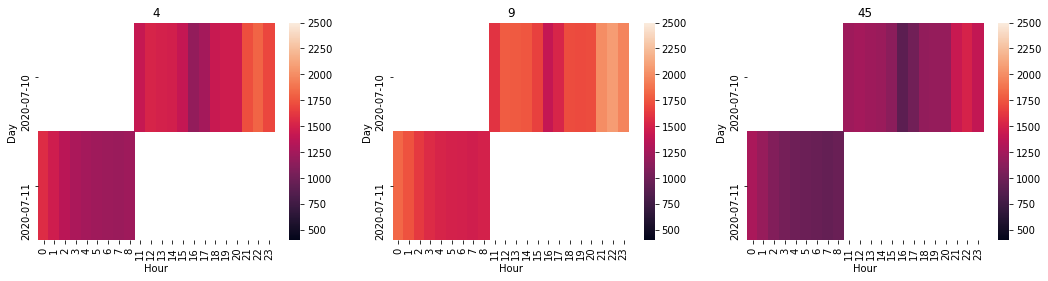

In [18]:
fig,ax = plt.subplots(1,3,figsize=(18,4))
loc = 0
for num in beacon_data['Beacon'].unique():
    # Getting dataframe for beacon in correct timeframe
    df_beacon = beacon_data[beacon_data['Beacon'] == num]
    df_beacon_timeframe = df_beacon[start_time:end_time]
    # Getting columns to pivot on
    df_beacon_timeframe['Hour'] = df_beacon_timeframe.index.hour
    df_beacon_timeframe['Day'] = df_beacon_timeframe.index.date
    # pivoting and plotting
    df_to_plot = df_beacon_timeframe.pivot_table(index='Day',columns='Hour',values='CO2')
    sns.heatmap(df_to_plot,vmin=400,vmax=2500,ax=ax[loc])
    ax[loc].set_title(num)
    
    loc += 1
    
plt.show()
plt.close()